# Evaluating artifacts from spectrogram thresholding by Delaunay triangulation on zeros

In [1]:
import numpy as np
from numpy import pi as pi
import matplotlib.pyplot as plt
from src.utilities.utilstf import *
from mcsm_benchs.Benchmark import Benchmark
from src.methods.method_delaunay_triangulation import delaunay_triangulation_denoising
import librosa
from src.aps_metric.perf_metrics import aps_measure
from IPython.display import Audio
import os

In [20]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [21]:
np.random.seed(0) 

In [22]:
s,fs = librosa.load('signals/cello.wav', sr=8000)
N = 8192
xmin = 0
s = s[xmin:xmin+N]
Audio(s, rate=fs)

In [23]:
SNRin = 30
noise = np.random.randn(N,)
signal,scaled_noise = Benchmark.sigmerge(s,noise,SNRin,return_noise=True)
Audio(signal, rate=fs)

In [24]:
Nfft = 2*1024
lbs = np.arange(1.0,2.3,0.1)

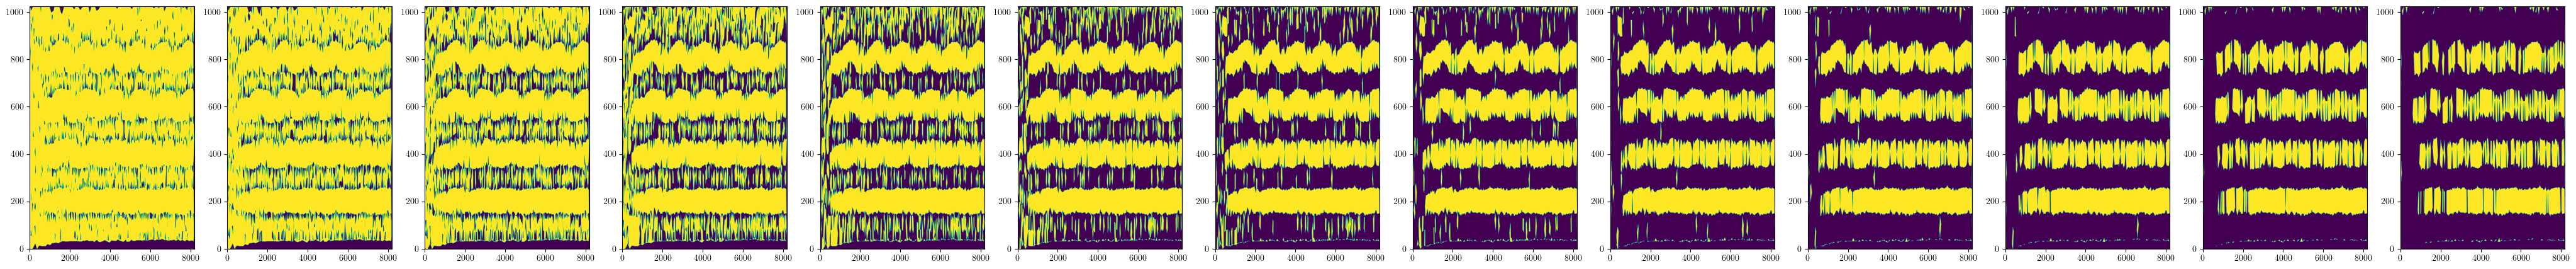

In [25]:
# Generate some example masks to show with the final figure.
fig, ax = plt.subplots(1,len(lbs),figsize = (4*len(lbs),5))
soutput = []
masks = []
for i,lb in enumerate(lbs):
    output = delaunay_triangulation_denoising(signal,
                                return_dic=True,
                                grouping = False,
                                adapt_thr=False,
                                min_group_size=5,
                                LB = lb,
                                Nfft=Nfft,
                                )                               

    signal_output, mask2, tri, tri_select, zeros = ( output[key] for key in 
                                    ('s_r','mask','tri','tri_select','zeros')
                                    )
    
    soutput.append(signal_output)
    masks.append(mask2.astype(bool))
    aps_out = aps_measure(s,scaled_noise,signal_output,fs)
    ax[i].imshow(mask2,origin='lower',aspect='auto')
    
plt.show()

In [26]:
# Parameters
thr = np.arange(0.25,6.0,0.25)
lmax = np.arange(1.0,2.2,0.1)
SNRs = [0, 10, 20, 30]
reps = 30
APS_dt = np.zeros((len(SNRs),len(lmax),reps),)

In [27]:
# Load the benchmark results for the cello signal
filename = os.path.join('..','results','benchmark_cello_APS')
benchmark_aps = Benchmark.load_benchmark(filename)
df_aps = benchmark_aps.get_results_as_df() # This formats the results on a DataFrame
df_aps

,Method,Parameter,Signal_id,Repetition,0,10,20,30
1410,dt,{'LB': 1.0},Signal 1,0,84.896372,86.738368,86.738368,86.738368
1411,dt,{'LB': 1.0},Signal 1,1,86.274503,86.738368,86.738368,86.738368
1412,dt,{'LB': 1.0},Signal 1,2,80.994591,86.738368,86.738368,86.738368
1413,dt,{'LB': 1.0},Signal 1,3,85.124223,86.738368,86.738368,86.738368
1414,dt,{'LB': 1.0},Signal 1,4,78.686653,86.738368,86.738368,86.738368
...,...,...,...,...,...,...,...,...
1345,ht,{'coeff': 5.75},Signal 1,25,0.300020,11.956271,6.709617,33.467687
1346,ht,{'coeff': 5.75},Signal 1,26,4.399308,9.719192,5.562318,28.486414
1347,ht,{'coeff': 5.75},Signal 1,27,0.012634,15.267371,8.457553,29.581366
1348,ht,{'coeff': 5.75},Signal 1,28,0.003339,13.364246,9.264105,32.189820


In [28]:
dt_params = np.unique(df_aps['Parameter'][df_aps['Method']=='dt'])
thr_params = np.unique(df_aps['Parameter'][df_aps['Method']=='ht'])
for i,snr in enumerate(SNRs):
    for j,lb in enumerate(dt_params):
        APS_dt[i,j,:] = df_aps[snr][df_aps['Parameter']==lb]

2.100000000000001

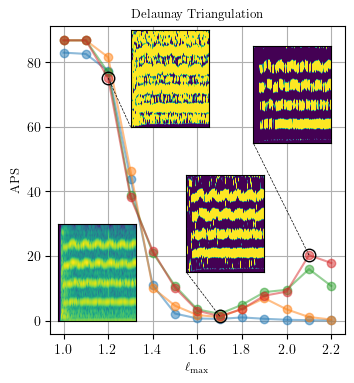

In [29]:
# Plotting APS vs. lmax from benchmark results.
fig, ax = plt.subplots(1,1, figsize=(3.8,4))
for q in range(len(SNRs)):
    # ax.plot(distortion,np.mean(DeltaK_PI_ht[q,:,0:8],axis=1))
    ax.plot(lmax,np.mean(APS_dt[q,:,:],axis=1),'-o',alpha=0.5,label='SNR={}'.format(SNRs[q]))

mean30 = np.mean(APS_dt[-1,:,:],axis=1)

# Insets axis with masks
# --1--
origin_inset = 1.3, 60
axins = ax.inset_axes([*origin_inset, 0.35, 30], transform=ax.transData)
axins.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
axins.imshow(masks[2],origin='lower',aspect='auto')
ax.plot([lmax[2],origin_inset[0]],[mean30[2],origin_inset[1]],'--k', linewidth=0.5)
ax.plot([lmax[2]],[mean30[2]],'ok', linewidth=0.5, ms=9.0,markerfacecolor='none')

# --2--
origin_inset = 1.55, 15
axins = ax.inset_axes([*origin_inset, 0.35, 30], transform=ax.transData)
axins.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
axins.imshow(masks[7],origin='lower',aspect='auto')
ax.plot([lmax[7],origin_inset[0]],[mean30[7],origin_inset[1]],'--k', linewidth=0.5)
ax.plot([lmax[7]],[mean30[7]],'ok', linewidth=0.5, ms=9.0, markerfacecolor='none')

# --3--
origin_inset = 1.85, 55
axins = ax.inset_axes([*origin_inset, 0.35, 30], transform=ax.transData)
axins.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
axins.imshow(masks[11],origin='lower',aspect='auto')
ax.plot([lmax[11],origin_inset[0]],[mean30[11],origin_inset[1]],'--k', linewidth=0.5)
ax.plot([lmax[11]],[mean30[11]],'ok', linewidth=0.5, ms=9.0, markerfacecolor='none')

# --4-- Spectrogram
origin_inset = 0.975, 0.0
axins = ax.inset_axes([*origin_inset, 0.35, 30], transform=ax.transData)
axins.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
S, F = get_spectrogram(s,Nfft=Nfft)
axins.imshow(np.log(np.abs(F[0:Nfft//2])+1e-6),origin='lower',aspect='auto')
# axins.imshow(S,origin='lower',aspect='auto')

# Legends
ax.set_title('Delaunay Triangulation', fontsize=9.0)
ax.set_xlabel(r"$\ell_{\max}$", fontsize=9.0)
ax.set_ylabel(r"APS", fontsize=9.0)
# ax.legend()
ax.grid(True)

# Save figure
fig.savefig('figures/cello_APS_dt.pdf', dpi=900, transparent=False, bbox_inches='tight')